# Retrieval

In [30]:
import cv2
import face_recognition
import keras
import joblib
import numpy as np
import pickle
import os
import sklearn
import warnings
from google_images_download import google_images_download
from time import time
from tqdm import tqdm


import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.pyplot import imshow, show
from PIL import Image, ImageEnhance

from keras_vggface import utils
from keras.preprocessing import image as kimage
from keras.applications import inception_v3
from keras.applications.inception_v3 import preprocess_input
from skimage import feature
from sklearn.neighbors import KDTree
from joblib import dump, load

In [5]:
def nn_inception(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_v3.preprocess_input(x)
    f = nn.predict(x)
    return f.flatten()

In [12]:
def VGGFace_prep(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x)
    f = vgg_features.predict(x)
    return f.flatten()

In [11]:
!pip install keras_vggface
from keras_applications.imagenet_utils import _obtain_input_shape
from keras_vggface.vggface import VGGFace

In [26]:
nn = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling='max')

In [18]:
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

58916864/58909280 [==============================] - ETA:  - ETA: 4: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 51 - ETA: 49 - ETA: 43 - ETA: 40 - ETA: 37 - ETA: 34 - ETA: 31 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 

In [27]:
joblib.dump(nn, 'nn.joblib')
joblib.dump(vgg_features, 'vgg_features.joblib')

['vgg_features.joblib']

In [31]:
vgg_features = load('vgg_features.joblib')

<font size=3>
    
Caricamento del vettore di features creato su Colab.

In [38]:
# X_train, paths = load_data(feature_extractor=nn_inception)
X_train = np.load('Xtrain_vgg (3).npy')

In [21]:
with open('paths_list', 'rb') as fp:
    paths = pickle.load(fp)

# Costruzione albero di ricerca

In [6]:
def load_image(base_path):
    img_list = []
    
    for fi,f in enumerate(tqdm(sorted(os.listdir(base_path)))):
        if f.endswith('.jpg'):
            query_image = kimage.load_img(base_path + f, target_size=(299, 299))
            img_list.append(query_image)
        
    return img_list

<font size=3>
    
Per il task di retrieval viene inizializzato un albero mediante la funzione ``KDTree``. Questa funzione crea un albero binario a partire da un vettore di features che sarà successivamente interrogato per trovare le immagini più simili ad una data in input.
<br></br>

La costruzione di un albero permette la ricerca di immagini simili fra loro anche dando un insieme molto elevato. L'approccio classico brute-force sarebbe quello di cercare le similarità fra fra tutte le feature delle immagini, tuttavia se già dopo poche analisi si evidenzia che non esiste una stretta similarità è inutile continuare nelle operazioni per ottenere un risultato scontato. Questo albero effettua esattamente questo procedimento, calcola solo le distanze che sono necessarie per abbattere i tempi computazionali.
<br></br>
Di default il metodo calcola le distanze sulla distanza di Minkowski con $p=2$ che coincide con la distanza euclidea.

In [39]:
start = time()
tree = KDTree(X_train)
end = time()
print("Creazione dell'albero in", str(end-start))

Creazione dell'albero in 23.72590708732605


In [ ]:
del X_train

<font size=3>
    
Salvataggio e loading dell'albero per le future iterazioni.

In [40]:
joblib.dump(tree, 'tree_vgg.joblib')

['tree_vgg.joblib']

In [9]:
tree = None
tree = joblib.load('tree.joblib') 

<font size=3>
    
La funzione ``retrieval`` sono caricate le immagini e viene effettuata la ricerca delle foto più simili. La funzione prende in input i seguenti parametri:
* <b>base_path</b>: directory in cui sono presenti delle cartelle contenenti immagini.
* <b>b:</b> valore booleano, se vero viene effettuata un'aggiustamento della luminosità
* <b>bgrigtness</b>: una lista che deve essere composta da $3$ elementi per effettuare una regolazione della luminosità. Il primo valore è il minimo affinché venga effettuata, il secondo il massimo, l'ultimo valore indica di quanto dovrà essere modificata.
* <b>index</b>: valore numerico in una lista che indica l'indice della foto nelle directory che dovrà essere considerato.
* <b>face</b>: valore booleano, se vero verrà fatta una face recognition.
* <b>prep</b>: valore booleano, se vero verrà fatto un preprocessing.
<br></br>

Per la visualizzazione viene creato un subplot di una riga e due colonne. L'immagine di destra sarà quella analizzata (quella caricata ed eventualmente preprocessata), mentre a sinista si crea un ulteriore subplot in cui verranno inserite in una griglia $3x3$ le immagini più simili.

In [36]:
def retrieval(base_path, brightness, index, method, b=True, face=True, prep=False):
    warnings.filterwarnings("ignore")
    
    for di, d in enumerate(sorted(os.listdir(base_path))):
        for fi, f in enumerate(sorted(os.listdir(base_path + d + '/'))):

            # carica l'immagine corrispondente all'indice generato casualmente
            if f.endswith('.jpg') and fi == index[0]:
                fig = plt.figure(figsize=(15, 7))
                image = face_recognition.load_image_file(base_path + d + '/' + f)

                """
                Alcune foto risultano essere molto scure. Questo non era un grosso problema per il task
                di riconoscimento immagini fra due classi, anche senza delle modifiche le performance
                erano quasi ottimali. In questo caso tuttavia dopo qualche prova è risultato evidente
                che la regolazione della luminosità fosse necessaria per procedere appropriatamente con
                questo task.
                """
                    
                if face:
                    face_locations = face_recognition.face_locations(image)
                    if len(face_locations) > 0:
                        top, right, bottom, left = face_locations[0][0:4]
                        image = image[top:bottom, left:right]

                image = np.array(image)
                
                if prep:
                    image = cv2.bilateralFilter(image, 9, 20, 20)
                 
                
                """
                I possibili modelli da utilizzare sono InceptionV3 identificato come 'nn' 
                e vggFace indicato come 'vgg'. Questi due modelli richiedono una dimensione
                in input diversa. Se il nome indicato non è uno dei due viene printato un errore
                """
                if method == "vgg":
                    face_image = cv2.resize(image, dsize=(224, 224)) 
                elif method == "nn":
                    face_image = cv2.resize(image, dsize=(299, 299)) 
                else:
                    raise Exception("Modello selezionato non valido")
                
                # Regolazione della brightness in base ai valori in input
                if b:
                    try:
                        bright = np.mean(face_image[face_image])
                        brt = brightness[2]
                        if bright < brightness[0]:
                            face_image[face_image < 255-brt] += brt
                        if bright > brightness[1]:
                            face_image[face_image < 255-brt] -= brt
                        del bright
                    except IndexError:
                        pass
                
                # Viene inizializzata un griglia per la rappresentazione dei risultati
                gs0 = gridspec.GridSpec(1, 2, width_ratios=[3, 3], hspace=1)
                gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
                gs01 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[1])

                ax00 = fig.add_subplot(gs00[0, 0])
                ax00.imshow(face_image)
                ax00.set_xticks([])
                ax00.set_yticks([])


                # metodo per il preprocessing
                if method == "vgg":
                    query_features = VGGFace_prep(face_image).reshape(1,-1)
                else:
                    query_features = nn_inception(face_image).reshape(1,-1)
                dist, ind = tree.query(query_features, k=10)

                
                """
                Viene stampata a video la lista delle distanze delle diverse immagini.
                Attraverso un doppio loop si selezionano le immagini con l'indice di riferimento
                e le si posizionano nella griglia per la visualizzazione.
                """
                print(dist)
                for i in range(3):
                    for j in range(3):
                        ax01 = fig.add_subplot(gs01[i, j])

                        if i == 1:
                            j += 3
                        elif i == 2:
                            j += 6

                        ax01.imshow(kimage.load_img(paths[ind[0][j]]))
                        ax01.set_xticks([])
                        ax01.set_yticks([])

                break
            plt.show()

In [ ]:
%matplotlib inline
index = np.random.randint(0, 80, 1)
index = [0]
retrieval(base_path='./rullino/', method='nn', index=index, b=False, prep=True, brightness=[130, 200, 30], face=True)

[[ 95.3930834   98.03804638  98.10314262  98.48709879 100.04631534
  100.2065112  100.36509572 100.45118013 101.37092456 101.53322716]]


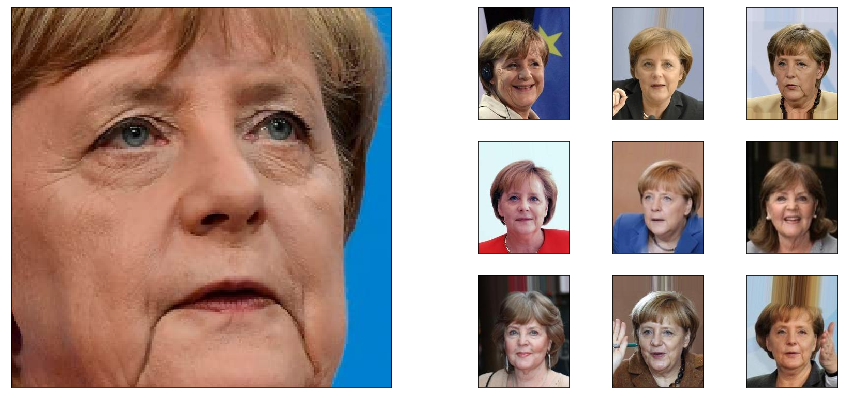

[[ 97.80332716  98.43997732  99.01716803  99.42425153  99.51750971
   99.52070423  99.78246718 100.14769317 100.40152408 100.46743806]]


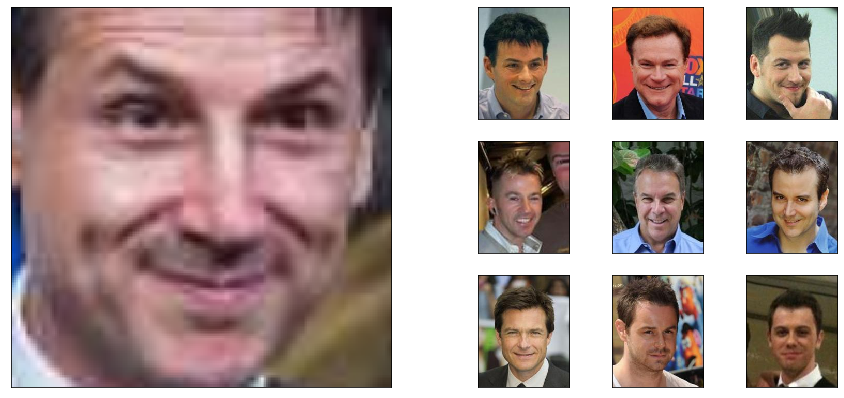

[[102.43960205 103.11613685 103.18372885 103.36692492 103.46774377
  103.6300175  103.82573305 104.07393704 104.17959715 104.34214614]]


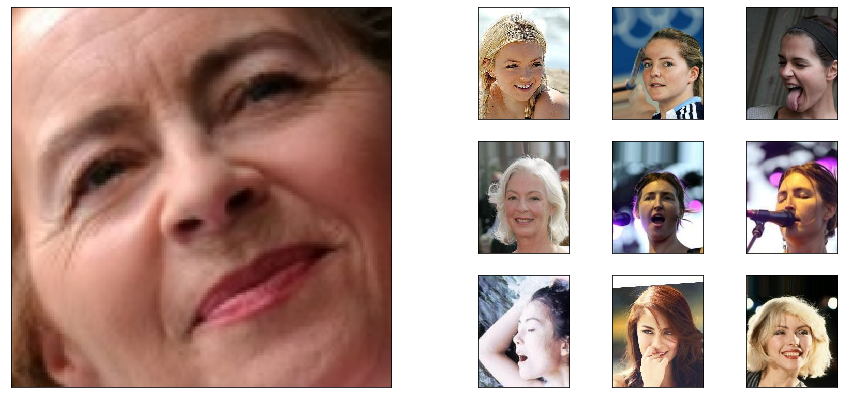

[[100.73931128 101.23345996 101.60226207 101.67773954 101.83204632
  102.26844247 102.29177885 102.86937995 102.89896315 103.15259838]]


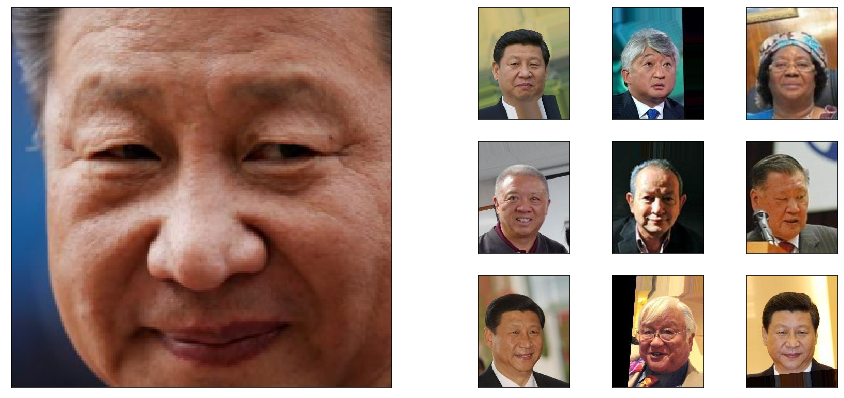

In [25]:
%matplotlib inline
#index = np.random.randint(0, 20, 1)
retrieval(base_path='./downloads/', index=[5], b=False, brightness=[130, 180, 30], face=True)